In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from importlib import reload
import pickle

import RNDPricer as rnd
reload(rnd)

<module 'RNDPricer' from '/Users/adammoszczynski/Desktop/research/Kalshi-Arb/RNDPricer.py'>

In [2]:
df = pd.read_csv('spx_w/eoy_chains.csv')
df.sort_values(['quote', 'strike'], inplace=True)
days = df['quote'].unique().tolist()

In [3]:
with open("kalshi_data.pkl", "rb") as f:
    kalshi_data = pickle.load(f)

## Hedge Evaluation

In [50]:
year = 2024
k_ticker = '5000.0-5199.99'
price_df = kalshi_data[year]["price"]
bid_df = kalshi_data[year]["bid"][k_ticker]
ask_df = kalshi_data[year]["ask"][k_ticker]

# ic strikes
k_1 = 4975
k_2 = 5000
k_3 = 5200
k_4 = 5225

days = df.loc[(df['quote'] >= str(year)+"-01-01") & (df['quote'] <= str(year)+"-12-31")]['quote'].unique().tolist()

day_info = []
for day in days:
    day_df = df[df['quote']==day].copy()
    
    if day_df.empty:
        print(f"Option data empty on {day}")
        continue
    
    # initializing RND
    try:
        rndp = rnd.RNDPricer(day_df)
    except ValueError:
        print(f"RND error on {day}")
        continue
    
    # check kalshi bucket data
    if day not in bid_df.index or day not in ask_df.index:
        print(f"Kalshi data missing {day}")
        continue
    
    # get kalshi prices
    kalshi_bid = bid_df.loc[day] / 100
    kalshi_ask = ask_df.loc[day] / 100
    
    if np.isnan(kalshi_bid) or np.isnan(kalshi_ask):
        #print('invalid kalshi quotes')
        continue
    
    #kalshi_mid = (kalshi_bid + kalshi_ask) / 2
    
    def get_opt_info(day_df, strike, opt_type):
        opt = day_df.loc[(day_df['strike']==strike) & (day_df['option_type']==opt_type)]

        return opt["Bid"].iloc[0], opt["Ask"].iloc[0]
    
    # get iron condor prices
    p1_b, p1_a = get_opt_info(day_df, k_1, 'p')
    #print(p1_a)
    #break
    
    
    p2_b, p2_a = get_opt_info(day_df, k_2, 'p')
    c3_b, c3_a = get_opt_info(day_df, k_3, 'c')
    c4_b, c4_a = get_opt_info(day_df, k_4, 'c')
    p1_mid = (p1_b + p1_a) / 2
    p2_mid = (p2_b + p2_a) / 2
    c3_mid = (c3_b + c3_a) / 2
    c4_mid = (c4_b + c4_a) / 2
    
    # combined contract
    ic_payoff = min((k_2 - k_1), (k_4 - k_3))
    ic_long = p1_a - p2_b - c3_b + c4_a
    ic_short = -p1_b + p2_a + c3_a - c4_b
    ic_mark_long = p1_mid - p2_mid - c3_mid + c4_mid  
    ic_mark_short = - p1_mid + p2_mid + c3_mid - c4_mid  
    
    temp_info = {
        "day" : day,
        "kbid" : kalshi_bid,
        "kask" : kalshi_ask,
        "ic_payoff" : ic_payoff,
        "ic_mark_long" : ic_mark_long,
        "ic_mark_short" : ic_mark_short
    }
    day_info.append(temp_info)
    

hedge_df = pd.DataFrame(day_info)
hedge_df.set_index('day', drop=True, inplace=True)

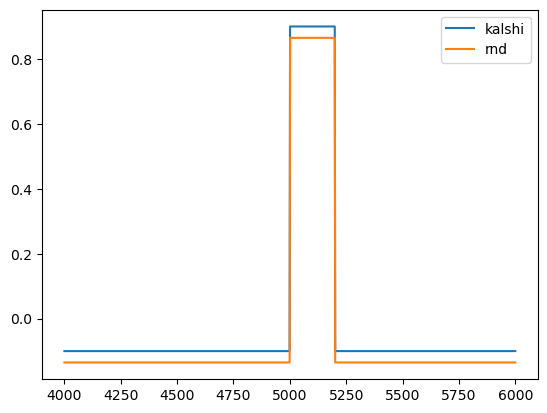

In [104]:
day_df = df[df['quote']=='2024-01-02'].copy()
rndp = rnd.RNDPricer(day_df)

buy_kalshi = hedge_df.iloc[0]['kbid']
rnd_p = rndp.price_bucket(5000, 5200)
buy_ic = hedge_df.iloc[0]['ic_mark_long']
sell_ic = hedge_df.iloc[0]['ic_mark_short']

k_qty = 25

# plotting the two payoffs over a range of final values:
def k_payoff(x):
    return 1 if x >= 5000 and x < 5200 else 0
k_func = np.vectorize(k_payoff)

def ic_payoff(x):
    p1 = max(k_1-x, 0)
    p2 = max(k_2-x, 0)
    c3 = max(x-k_3, 0)
    c4 = max(x-k_4, 0)

    return p1 - p2 - c3 + c4
ic_func = np.vectorize(ic_payoff)
   
x = np.linspace(4000, 6000, 1000)
#k_quantity = round(ic_payoff(5100) + sell_ic)
k_quantity = 1
k_payoffs = (k_func(x) - buy_kalshi) * k_quantity
rnd_payoffs = (k_func(x) - rnd_p) * k_quantity
#ic_payoffs = -ic_func(x) - sell_ic

#print(buy_ic, sell_ic)

plt.plot(x, k_payoffs, label='kalshi')
plt.plot(x, rnd_payoffs, label='rnd')
#plt.plot(x, ic_payoffs)
#plt.plot(x, k_payoffs - ic_payoffs)
plt.legend()
plt.show()

## Simple Mispricing Strategy

In [250]:
fees = 0.01
year = 2023

tickers = kalshi_data[year]["tickers"]
price_df = kalshi_data[year]["price"]
bid_df = kalshi_data[year]["bid"]
ask_df = kalshi_data[year]["ask"]

days = df.loc[(df['quote'] >= str(year)+"-01-01") & (df['quote'] <= str(year)+"-12-31")]['quote'].unique().tolist()

positions = []
for day in days:
    
    # Get option data for the day
    day_df = df[df['quote'] == day].copy()
    if day_df.empty:
        # No option data this day
        continue
    
    # Initialize RND pricer
    try:
        rndp = rnd.RNDPricer(day_df)
    except ValueError:
        # Could not initialize RND (e.g., empty chain)
        continue
    
    # Check Kalshi data availability
    if day not in bid_df.index or day not in ask_df.index:
        # No Kalshi data this day
        continue
    
    day_bids = bid_df.loc[day]
    day_asks = ask_df.loc[day]
    tradable_buckets = [
        col for col in day_bids.index 
        if not (pd.isnull(day_bids[col]) or pd.isnull(day_asks[col]))
    ]
    
    for bucket in tradable_buckets:
        
        kalshi_lower_str, kalshi_upper_str = bucket.split('-')
        kalshi_lower = float(kalshi_lower_str)
        kalshi_upper = float(kalshi_upper_str)
        
        # Kalshi market prices
        kalshi_bid = day_bids[bucket] / 100
        kalshi_ask = day_asks[bucket] / 100
        
        # Compute RND-implied price for the bucket
        rndprice = rndp.price_bucket(kalshi_lower, kalshi_upper)
        rndprice = round(rndprice, 2)
        
        if rndprice > (kalshi_ask + fees):
            positions.append({
                'day': day,
                'instrument': f'kalshi_{bucket}',
                'direction': 'buy',
                'executed_price': kalshi_ask + fees,
                'rnd_price': rndprice,
                'quantity':1
            })
        elif rndprice < (kalshi_bid - fees):
            positions.append({
                'day': day,
                'instrument': f'kalshi_{bucket}',
                'direction': 'sell',
                'executed_price': kalshi_bid - fees,
                'rnd_price': rndprice,
                'quantity':-1
            })
        


In [251]:
# parse positions into dataframe
positions_df = pd.DataFrame(positions)
positions_df

,day,instrument,direction,executed_price,rnd_price,quantity
0,2023-01-03,kalshi_2700.0-2899.99,sell,0.03,0.02,-1
1,2023-01-03,kalshi_2900.0-3099.99,sell,0.04,0.02,-1
2,2023-01-03,kalshi_3100.0-3299.99,sell,0.05,0.03,-1
3,2023-01-03,kalshi_3300.0-3499.99,sell,0.09,0.04,-1
4,2023-01-03,kalshi_3500.0-3699.99,sell,0.11,0.04,-1
...,...,...,...,...,...,...
982,2023-12-28,kalshi_4700.0-4899.99,sell,0.86,0.09,-1
983,2023-12-28,kalshi_4900.0-5099.99,buy,0.04,0.12,1
984,2023-12-29,kalshi_4500.0-4699.99,buy,0.04,0.07,1
985,2023-12-29,kalshi_4700.0-4899.99,sell,0.96,0.09,-1


In [274]:
def mark_instrument(day, instrument, bid_df, ask_df, quantity, last_price=np.nan):
    bucket = instrument.replace("kalshi_", "")
    if day not in bid_df.index or day not in ask_df.index or bucket not in bid_df.columns:
        return last_price
    
    kb = bid_df.loc[day, bucket] / 100
    ka = ask_df.loc[day, bucket] / 100
    if quantity > 0:
        return kb if not np.isnan(kb) else last_price
    elif quantity < 0:
        return ka if not np.isnan(ka) else last_price
    else:
        return 0.0
  
unique_days = sorted(days)
cash = 100
positions = {}
metrics = []
fees = 0.01

for d in unique_days:
    realized_pnl = 0.0
    unrealized_pnl = 0.0
    day_value = 0.0
    
    # Get rndpricer for this day
    day_df = df[df['quote'] == d].copy()
    rndp = rnd.RNDPricer(day_df)
    
    current_day_trades = positions_df[positions_df['day']==d]
    for _, trade in current_day_trades.iterrows():
        inst = trade['instrument']
        qty = trade['quantity']
        price = trade['executed_price']
        cost = qty * price
        
        # update cash (fees included)
        cash -= cost
        
        if inst not in positions:
            positions[inst] = {"quantity": qty, "cost_basis":cost}
        else:
            current_qty = positions[inst]['quantity']
            current_cost = positions[inst]['cost_basis']
            avg_cost = current_cost / current_qty
            
            new_qty = current_qty + qty
            close_qty = min(abs(qty), abs(current_qty))
            if current_qty > 0 and qty < 0:
                realized_pnl += (price - avg_cost) * close_qty
            elif current_qty <0 and qty > 0:
                realized_pnl += (avg_cost - price) * close_qty
            else:
                # trade is increasing position in the same direction
                pass
            
            # update position
            remaining_qty = current_qty + qty
            remaining_cost = current_cost - (avg_cost * close_qty) if close_qty > 0 else current_cost + cost
            
            
            if remaining_qty == 0:
                del positions[inst]                 
            else:
                if (current_qty * new_qty) > 0:
                    remaining_cost = current_cost + cost
                positions[inst] = {"quantity":remaining_qty, "cost_basis":remaining_cost}

    # mark to market unrealized pnl for open positions
    rnd_pv = 0.0
    for inst, pos in positions.items():
        qty = pos['quantity']
        last_price = pos.get("last_price", 0.0)
        mprice = mark_instrument(d, inst, bid_df, ask_df, qty, last_price)
        if not pd.isnull(mprice): # should not be null but keeping condition
            day_value += qty * mprice
            unrealized_pnl += qty * mprice - pos['cost_basis']
            positions[inst]['last_price'] = mprice
        
        # mark to model
        bucket = inst.replace("kalshi_", "")
        kalshi_lower_str, kalshi_upper_str = bucket.split('-')
        kalshi_lower = float(kalshi_lower_str)
        kalshi_upper = float(kalshi_upper_str)
        rnd_price = rndp.price_bucket(kalshi_lower, kalshi_upper)
        rnd_pv += (rnd_price * qty) + (fees * qty)
    
        
    portfolio_val = cash + day_value
    rnd_pv += cash
    metrics.append({
        "day":d,
        "portfolio_value":portfolio_val,
        "theoretical_value":rnd_pv,
        "cash":cash,
        "realized_pnl":realized_pnl,
        "unrealized_pnl":unrealized_pnl
    })
     
        
metrics_df = pd.DataFrame(metrics)
metrics_df['day'] = pd.to_datetime(metrics_df['day'])
metrics_df.set_index('day', inplace=True)

# cumulative pnl
metrics_df['total_pnl'] = metrics_df['realized_pnl'].cumsum() + metrics_df['unrealized_pnl']

metrics_df

,portfolio_value,theoretical_value,cash,realized_pnl,unrealized_pnl,total_pnl
day,,,,,,
2023-01-03,99.17,100.245596,100.60,0.000000,-0.83,-0.830000
2023-01-04,99.52,100.418248,101.05,0.000000,-0.48,-0.480000
2023-01-05,99.29,100.489615,101.59,0.000000,-0.71,-0.710000
2023-01-06,98.99,100.708190,101.91,0.000000,-1.01,-1.010000
2023-01-09,99.03,100.822467,102.28,0.000000,-0.97,-0.970000
...,...,...,...,...,...,...
2023-12-22,172.65,94.177190,87.76,0.621419,74.15,72.771421
2023-12-26,158.07,96.913703,88.46,0.426704,59.57,58.618125
2023-12-27,162.05,97.761305,89.23,0.486454,63.55,63.084579


In [ ]:
#metrics_df['month'] = metrics_df.index.to_period('M')
#monthly_mean_pv = metrics_df.groupby('month')['portfolio_value'].mean()
#monthly_interest = monthly_mean_pv * (0.04 / 12)
#metrics_df['interest_payout'] = 0.0

#for month, interest in monthly_interest.items():
#    last_day = metrics_df.loc[metrics_df['month']==month].index[-1]
#    
#    metrics_df.loc[last_day, 'cash'] += interest
#    metrics_df.loc[last_day, 'interest_payout'] = interest

[]

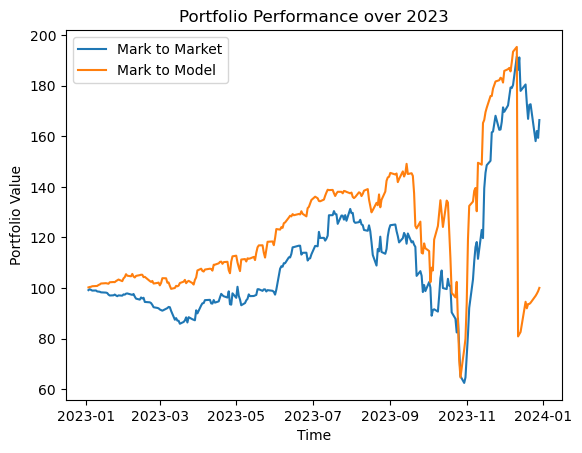

In [275]:
plt.plot(metrics_df['portfolio_value'], label='Mark to Market')
plt.plot(metrics_df['theoretical_value'], label='Mark to Model')
plt.title("Portfolio Performance over 2023")
plt.xlabel('Time')
plt.ylabel('Portfolio Value')
plt.legend()
plt.plot()

In [350]:
returns = metrics_df['portfolio_value'].pct_change().dropna()
mean_return = returns.mean()
ann_return = mean_return * len(days)

#total_pnl = metrics_df.iloc[-1]['total_pnl']

ann_vol = np.std(returns) * np.sqrt(len(days))
ann_sharpe = (ann_return - 0.03) / ann_vol

print(ann_return, ann_vol, ann_sharpe)

0.6819979134754083 0.5703429262876087 1.1431682298916128


In [276]:
ntrades = len(positions_df)
print(ntrades)
trades_per_contract = positions_df.groupby('instrument')['instrument'].count()

987


[]

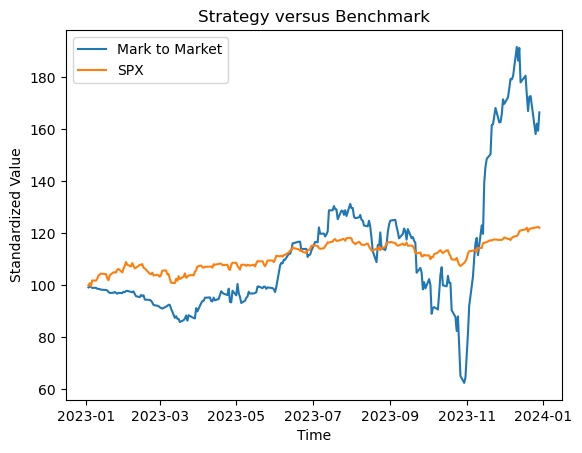

In [302]:
all_SPX = df[(df['quote']>='2023-01-01') & (df['quote']<'2024-01-01')]
all_SPX = all_SPX[['quote', 'underlying']].sort_values('quote')
all_SPX = all_SPX.drop_duplicates().set_index('quote')
#spx_returns = #np.log(all_SPX['underlying'].diff())
all_SPX['log_p'] = np.log(all_SPX['underlying'])
all_SPX['log_return'] = all_SPX['log_p'].diff().fillna(0)
all_SPX['cumulative'] = all_SPX['log_return'].cumsum()
all_SPX['spx_p'] = 100 * (1 + all_SPX['cumulative'])
all_SPX.index = pd.to_datetime(all_SPX.index)

#all_SPX
plt.plot(metrics_df['portfolio_value'], label='Mark to Market')
plt.plot(all_SPX['spx_p'], label='SPX')
plt.title("Strategy versus Benchmark")
plt.xlabel('Time')
plt.ylabel('Standardized Value')
plt.legend()
plt.plot()

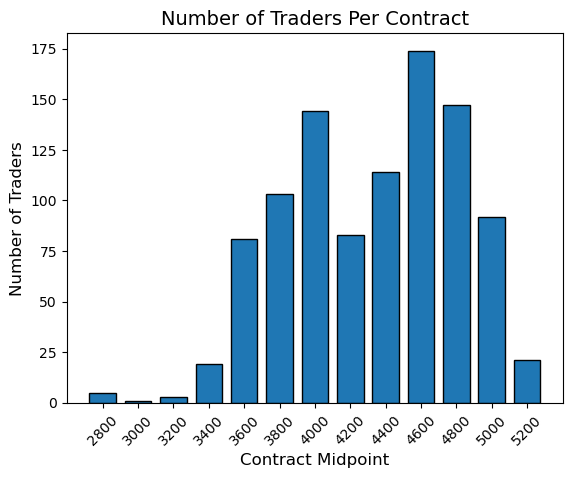

In [321]:
trades_per_contract

trades_df = pd.DataFrame(trades_per_contract)
trades_df['instrument_name'] = trades_df.index
trades_df = trades_df.reset_index(drop=True)

trades_df['midpoint'] = trades_df['instrument_name'].apply(
    lambda x: float(x.split('-')[0].split('_')[1]) + 100
)

trades_df
plt.bar(trades_df["midpoint"], trades_df["instrument"], width=150, edgecolor="black")
plt.xlabel("Contract Midpoint", fontsize=12)
plt.ylabel("Number of Traders", fontsize=12)
plt.title("Number of Traders Per Contract", fontsize=14)
plt.xticks(trades_df["midpoint"], rotation=45)
#plt.grid(axis='y', linestyle='--', alpha=0.7)
#plt.tight_layout()
plt.show()

In [336]:
# maximum drawdown
pv = all_SPX['underlying']
pv_max = pv.cummax()
drawdown = (pv - pv_max) / pv_max
drawdown.min()

-0.10276620410724874

In [353]:
# spx sharpe
spx_annr = all_SPX['log_return'].mean() * 252
spx_vol = all_SPX['log_return'].std() * np.sqrt(252)

spx_sr = (spx_annr - 0.03) / spx_vol

all_SPX

,underlying,log_p,log_return,cumulative,spx_p
quote,,,,,
2023-01-03,3824.14,8.249089,0.000000,0.000000,100.000000
2023-01-04,3852.97,8.256600,0.007511,0.007511,100.751067
2023-01-05,3808.10,8.244886,-0.011714,-0.004203,99.579677
2023-01-06,3895.08,8.267469,0.022584,0.018381,101.838061
2023-01-09,3892.09,8.266702,-0.000768,0.017613,101.761268
...,...,...,...,...,...
2023-12-22,4754.63,8.466874,0.001659,0.217785,121.778527
2023-12-26,4774.75,8.471097,0.004223,0.222008,122.200801
2023-12-27,4781.58,8.472526,0.001429,0.223437,122.343743


## Hedging Strategy
to be adjusted

In [4]:
fees = 0.01
year = 2023
max_K_distance = 250

tickers = kalshi_data[year]["tickers"]
price_df = kalshi_data[year]["price"]
bid_df = kalshi_data[year]["bid"]
ask_df = kalshi_data[year]["ask"]

days = df.loc[(df['quote'] >= str(year)+"-01-01") & (df['quote'] <= str(year)+"-12-31")]['quote'].unique().tolist()

positions = []

for day in days:
    # getting option data
    day_df = df[df['quote']==day].copy()
    if day_df.empty:
        print(f"Option data empty on {day}")
        continue
    
    # initializing RND
    try:
        rndp = rnd.RNDPricer(day_df)
    except ValueError:
        print(f"RND error on {day}")
        continue
    
    # check kalshi bucket data
    if day not in bid_df.index or day not in ask_df.index:
        print(f"Kalshi data missing {day}")
        continue
    
    day_bids = bid_df.loc[day]
    day_asks = ask_df.loc[day]
    tradable_buckets = [col for col in day_bids.index if not (pd.isnull(day_bids[col]) or pd.isnull(day_asks[col]))]

    for bucket in tradable_buckets:
        
        kalshi_lower_str = bucket.split('-')[0]
        kalshi_upper_str = bucket.split('-')[1]
        kalshi_lower = float(kalshi_lower_str)
        kalshi_upper = float(kalshi_upper_str)
        
        # kalshi market prices
        kalshi_bid = day_bids[bucket] / 100
        kalshi_ask = day_asks[bucket] / 100
        
        # pricing these contracts
        #print(kalshi_lower, kalshi_upper)
        rndprice = np.round(rndp.price_bucket(kalshi_lower, kalshi_upper), 2)
        
        # determininng mispricing:
        if rndprice > kalshi_ask:
            # underpriced from kalshi perspective
            # hedge by selling iron condor from SPX
            direction = "buy"
        if rndprice < kalshi_ask:
            # overpriced from kalshi perspective
            # hedge by buying iron condor from SPX
            #print(rndprice, kalshi_ask)
            direction = "sell"
        else:
            continue
        
        # finding equivalent SPX iron condor
        p_strikes = sorted(day_df[day_df['option_type']=='p']['strike'].unique())
        c_strikes = sorted(day_df[day_df['option_type']=='c']['strike'].unique())
        
        K1 = max([s for s in p_strikes if s < kalshi_lower], default=None)
        K2 = min([s for s in p_strikes if s >= kalshi_lower], default=None)       
        
        K3 = max([s for s in c_strikes if s <= kalshi_upper+0.01], default=None)
        K4 = min([s for s in c_strikes if s > kalshi_upper+0.01], default=None)
        
        # skip if no equivalent SPX iron condor
        if (K1 is None) or (K2 is None) or (K3 is None) or (K4 is None):
            continue
        
        underlying_today = day_df['underlying'].iloc[0]
        if (abs(K1 - underlying_today) > max_K_distance or 
            abs(K2 - underlying_today) > max_K_distance or 
            abs(K3 - underlying_today) > max_K_distance or 
            abs(K4 - underlying_today) > max_K_distance):
            continue # skip trade, too far OTM
        
        # getting iron condor price
        def get_price(quote_df, strike, opt_type, side):
            subset = quote_df[(quote_df['strike']==strike) & (quote_df['option_type']==opt_type)]
            if subset.empty:
                return None
            
            bid_p = subset.iloc[0]['Bid']
            ask_p = subset.iloc[0]['Ask']
            return ask_p if side=='buy' else bid_p
        
        if direction=="buy": # buying kalshi, selling ironcondor
            k1_dir = 'sell'
            k2_dir = 'buy'
            k3_dir = 'buy'
            k4_dir = 'sell'
            
            kalshi_price = kalshi_ask
            kalshi_dir = 'buy'
        else:
            k1_dir = 'buy'
            k2_dir = 'sell'
            k3_dir = 'sell'
            k4_dir = 'buy'
            
            kalshi_price = kalshi_bid
            kalshi_dir = 'sell'
            
        k1_put_p = get_price(day_df, K1, 'p', k1_dir)
        k2_put_p = get_price(day_df, K2, 'p', k2_dir)
        k3_call_p = get_price(day_df, K3, 'c', k3_dir)
        k4_call_p = get_price(day_df, K4, 'c', k4_dir)
        
        
        # continue if any nulls
        if any([p is None for p in [k1_put_p, k2_put_p, k3_call_p, k4_call_p]]):
            continue
        
        # TODO: adjust qty later
        max_ic_payoff = 100 * min((K2 - K1), (K4 - K3))
        kalshi_qty = int(max_ic_payoff)
        spx_qty = 1
        
        # kalshi contract price
        positions.append({
            'day':day, 
            'instrument':f'kalshi_{bucket}', 
            'quantity': kalshi_qty if kalshi_dir == "buy" else -kalshi_qty, 'price': kalshi_price,
            'rnd_price': rndprice}
        )
        
        # spxw contract price (hedging kalshi)
        def side_to_qty(side):
            return spx_qty if side == 'buy' else -spx_qty
        
        positions.append({
            'day': day, 
            'instrument': f'put_{K1}', 
            'quantity': side_to_qty(k1_dir), 
            'price': k1_put_p, 'rnd_price':np.nan}
        )
        positions.append({
            'day': day, 
            'instrument': f'put_{K2}', 
            'quantity': side_to_qty(k2_dir), 
            'price': k2_put_p, 'rnd_price':np.nan}
        )
        positions.append({
            'day': day, 
            'instrument': f'call_{K3}', 
            'quantity': side_to_qty(k3_dir), 
            'price': k3_call_p, 'rnd_price':np.nan}
        )
        positions.append({
            'day': day, 
            'instrument': f'call_{K4}', 
            'quantity': side_to_qty(k4_dir), 
            'price': k4_call_p, 'rnd_price':np.nan}
        )
        

In [5]:
# parse positions into dataframe
positions_df = pd.DataFrame(positions)

positions_df
#for day in positions_df['day'].unique():
#    print(day)

,day,instrument,quantity,price,rnd_price
0,2023-01-03,kalshi_3700.0-3899.99,-2500,0.20,0.06
1,2023-01-03,put_3675.0,1,240.80,NaN
2,2023-01-03,put_3700.0,-1,243.50,NaN
3,2023-01-03,call_3900.0,-1,360.40,NaN
4,2023-01-03,call_3925.0,1,354.70,NaN
...,...,...,...,...,...
775,2023-12-29,kalshi_4700.0-4899.99,-2500,0.97,0.09
776,2023-12-29,put_4675.0,1,198.70,NaN
777,2023-12-29,put_4700.0,-1,201.30,NaN
778,2023-12-29,call_4900.0,-1,310.00,NaN


In [6]:
# track evolution of one portfolio
positions_df.groupby('day')

positions_df.groupby('instrument')['quantity'].sum()

instrument
call_3900.0                 -13
call_3925.0                  13
call_4100.0                 -59
call_4105.0                   2
call_4125.0                  57
call_4300.0                 -29
call_4305.0                  13
call_4325.0                  16
call_4500.0                 -23
call_4505.0                  19
call_4525.0                   4
call_4700.0                 -21
call_4705.0                  20
call_4725.0                   1
call_4900.0                 -11
call_4905.0                   2
call_4925.0                   9
kalshi_3700.0-3899.99    -32500
kalshi_3900.0-4099.99   -143500
kalshi_4100.0-4299.99    -46500
kalshi_4300.0-4499.99    -19500
kalshi_4500.0-4699.99    -12500
kalshi_4700.0-4899.99    -23500
put_3675.0                   13
put_3700.0                  -13
put_3875.0                   57
put_3895.0                    2
put_3900.0                  -59
put_4075.0                   16
put_4095.0                   13
put_4100.0                  -

In [7]:
def mark_instrument_side(day, instrument, df_options, bid_df, ask_df, quantity):
    if instrument.startswith("kalshi"):
        bucket = instrument.replace("kalshi_", "")
        if day not in bid_df.index or day not in ask_df.index or bucket not in bid_df.columns:
            return np.nan
        
        kb = bid_df.loc[day, bucket] / 100
        ka = ask_df.loc[day, bucket] / 100
        if quantity > 0:
            return ka
        elif quantity < 0:
            return kb
        
        return 0.0
    
    elif instrument.startswith("put_") or instrument.startswith("call_"):
        
        typ = 'p' if instrument.startswith("put_") else 'c'
        strike = float(instrument.split("_")[1])
        
        sub = df_options[(df_options['strike']==strike) & (df_options['option_type']==typ)]
        
        if sub.empty:
            return np.nan
        
        b = sub.iloc[0]["Bid"]
        a = sub.iloc[0]["Ask"]
        if pd.isnull(b) or pd.isnull(a):
            return np.nan
        if quantity > 0:
            return a
        elif quantity < 0:
            return b
        
        return 0.0
    
    else:
        return np.nan
    
unique_days = sorted(days)
portfolio_values = []
prev_value = 0.0

for d in unique_days:
    day_df_options = df[df['quote']==d].copy()
    day_value = 0.0
    
    current_positions = positions_df[positions_df["day"] <= d]
    
    position_agg = current_positions.groupby('instrument')['quantity'].sum().reset_index()
    
    for _, rowp in position_agg.iterrows():
        inst = rowp["instrument"]
        q = rowp["quantity"]
        mprice = mark_instrument_side(d, inst, day_df_options, bid_df, ask_df, q)
        if not pd.isnull(mprice):
            day_value += q*mprice
            
    portfolio_values.append({"day":d, "portfolio_value":day_value})
    prev_value = day_value
    
pnl_df = pd.DataFrame(portfolio_values)
pnl_df['pnl'] = pnl_df['portfolio_value'].diff().fillna(0)
pnl_df.index = pd.to_datetime(pnl_df['day'])
pnl_df.drop(columns=['day'], inplace=True)

In [146]:
pnl_df

,portfolio_value,pnl
day,,
2023-01-03,-508.4,0.0
2023-01-04,-666.0,-157.6
2023-01-05,-1025.4,-359.4
2023-01-06,-1331.2,-305.8
2023-01-09,-1967.0,-635.8
...,...,...
2023-12-22,-56614.4,-2792.9
2023-12-26,-58105.7,-1491.3
2023-12-27,-61090.5,-2984.8


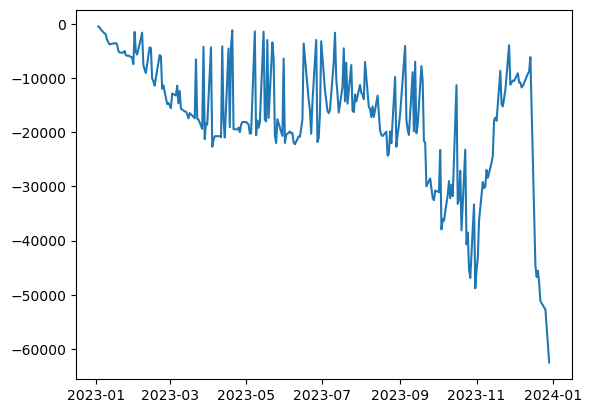

In [8]:
plt.plot(pnl_df['portfolio_value'])
plt.show()

In [97]:
final_day = unique_days[-1]
underlying_final = df[df['quote']==final_day]['underlying'].iloc[0]
underlying_final

5916.98

In [98]:
def final_payoff(instrument, underlying_price):
    if instrument.startswith("kalshi_"):
        # extract bucket
        bucket = instrument.replace("kalshi_", "")
        lower_str, upper_str = bucket.split('-')
        lower, upper = float(lower_str), float(upper_str)
        # If underlying_final is within [lower, upper], payoff = 1, else 0
        return 1.0 if (lower <= underlying_price <= upper) else 0.0
    
    elif instrument.startswith("put_"):
        strike = float(instrument.split('_')[1])
        return max(0, strike - underlying_price)
    
    elif instrument.startswith("call_"):
        strike = float(instrument.split('_')[1])
        return max(0, underlying_price - strike)
    
    else:
        # no known instrument type
        return np.nan
    
final_positions = positions_df.copy()
final_quantities = final_positions.groupby('instrument')['quantity'].sum().reset_index()

final_value = 0.0
for _, rowp in final_quantities.iterrows():
    inst = rowp["instrument"]
    q = rowp["quantity"]
    payoff = final_payoff(inst, underlying_final)
    final_value += q*payoff

print(final_value)

-5394.999999999993


## Checking Hedge Validity

In [ ]:
instruments_of_interest = positions_df['instrument'].unique().tolist()

data